In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import tensorflow_hub as hub
import json
from matplotlib.image import imread
import imutils
import numpy as np
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt

In [2]:
# APPROACH
# Image classification (instead of object detection)
# Model - mobilenet_v2 pretrained on ImageNet
# Transfer learning on the given dataset

# Load model from tensorflow hub
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=(224, 224, 3))])

IMAGE_SHAPE = (224,224) # according to MobileNetv2 model

# Path to the images of the given dataset
dataset_path = "assignment_imgs/"
# Path to the label mapping file
label_map_path = "label_mapping.csv"


In [3]:
annotations = {}
with open('img_annotations.json') as file:
    x = json.load(file)
    #print(build_j)
    annotations = x

# All the labels that contain notion of tomatoes
# TODO Automatic list creation from label mapping file with a key word (e.g. tomato)
tomato_labels = ["513535c5382eebf51dca54b46d570fe5_lab",
                 "939030726152341c154ba28629341da6_lab",
                 "9f2c42629209f86b2d5fbe152eb54803_lab",
                 "4e884654d97603dedb7e3bd8991335d0_lab",
                 "f3c12eecb7abc706b032ad9a387e6f01_lab",
                 "e306505b150e000f5e1b4f377ad688a0_lab",
                 "5816e75b36aa2708f126fe22abeda6ed_lab",
                 "4e2da86105869fc35c947c1b467a7f96_lab",
                 "fb9547240ac8bb62713892d7e83e7ce2_lab",
                 "c262e42a627986076c07c4a194946a93_lab",
                 "a4abc986701f1759315bae54ba51198e_lab",
                 "9de66567ece99ca7265921bf54cc6b9f_lab",
                 "7381c4a68441e0a72ab8c4783b5c1068_lab"]


new_labels = {}
filenames = []
labels = []

for img in annotations:
  filenames.append(img)
  for det in annotations[img]:
    # check if at least one object in the image is a tomato
    if det["id"] in tomato_labels:
      labels.append([1,0])
      new_labels[img] = np.array([1,0]) # tomato
      continue
  if img not in new_labels:
    labels.append([0,1])
    new_labels[img] = np.array([0,1]) # no tomato


In [5]:
# split the data into train, val, test subsets

split_1 = int(0.8 * len(filenames))
split_2 = int(0.9 * len(filenames))


# read dataset images into an array
x = np.zeros((len(filenames),224,224,3))
z = 0
for filename in filenames:
  i = Image.open(dataset_path+filename).resize((224, 224))
  i.load()
  data = np.asarray( i, dtype="int32" )
  x[z] =data
  z = z+1

print(x.shape)


train_x = x[:split_1]
val_x = x[split_1:split_2]
test_x = x[split_2:]

train_y = labels[:split_1]
val_y = labels[split_1:split_2]
test_y = labels[split_2:]

# create training and validation data
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow(train_x, train_y, batch_size=16)
validation_data = image_generator.flow(val_x, val_y, batch_size=16)


(3000, 224, 224, 3)


In [8]:
# Freeze feature extractor layer
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_extractor_layer.trainable = False

# Create new layer to train on new dataset and labels
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
steps_per_epoch = np.ceil(2400/16)
#steps_per_epoch = 10
batch_stats_callback = CollectBatchStats()
t = time.time()

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)


history = model.fit_generator(image_data, validation_data=validation_data,
								epochs=3,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


W1128 15:50:54.288901 140240972314432 callbacks.py:863] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Epoch 1/3
150/150 [==============================] - 160s 1s/step - loss: 0.6441 - acc: 0.7500 - val_loss: 0.6377 - val_acc: 0.7133
Epoch 2/3
150/150 [==============================] - 161s 1s/step - loss: 0.5413 - acc: 0.8125 - val_loss: 0.6608 - val_acc: 0.6967
Epoch 3/3
150/150 [==============================] - 161s 1s/step - loss: 0.5009 - acc: 0.7500 - val_loss: 0.6602 - val_acc: 0.7433


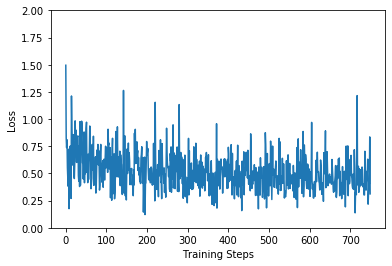

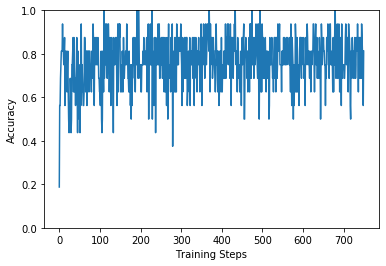

In [10]:
# Print plot of loss and Accuracy of training

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()


plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()



In [10]:
# Export model to file

export_path = "saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')


W1128 16:57:43.732640 140240972314432 deprecation.py:506] From /home/cbi/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
